# Scraping
To start, we have a folder of 40 HTML files that we are going to scrape the housing data from. We start by creating an array with all of the file names, then we can open each file to get its data.

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import re

# the names of every html file that is going to have its data scraped
filenames = [];
for i in range(1, 41):
    if i < 10:
        filenames += [f"kungalv_slutpriser/kungalv_slutpris_page_0{i}.html"]
    else:
        filenames += [f"kungalv_slutpriser/kungalv_slutpris_page_{i}.html"]

values = []

Now that we have all of the file names, we can fill up the `values` array with the data that we are looking for. This process looks different for each data point, but the main idea is that we find a uniquely identifiable DOM object, and then work our way to the nearby data from there.

In [4]:
for filename in filenames:
    with open(filename, 'r', encoding="utf-8") as f:
        html = f.read()

    soup = BeautifulSoup(html, 'html.parser')

    for cell in soup.find_all('li', class_ = 'sold-results__normal-hit'):
        # card is the current "card" on the page that contains the information for one house
        card = cell.a.div

        date_sold = card.find('span', class_ = 'hcl-label--sold-at').text.strip()
        sold_tokens = date_sold.split(' ')
        date_sold = sold_tokens[1] + " " + sold_tokens[2] + " " + sold_tokens[3]

        address = card.find('h2', class_ = 'sold-property-listing__heading').text.strip()

        location = card.find('div', class_ = 'sold-property-listing__location').div.text.strip()[24:]
        location_tokens = location.split(',')

        for i in range (0, len(location_tokens)):
            location_tokens[i] = re.search("(\\w+.*)", location_tokens[i]).group(1)
        location = location_tokens[0]
        for i in range(1, len(location_tokens)):
            location += (", " + location_tokens[i])

        living_area_and_rooms = card.find('div', class_ = 'sold-property-listing__area')
        contains_m2 = living_area_and_rooms.text.strip().find('m²')
        laar_tokens = living_area_and_rooms.text.strip().split('m²')
        living_area = ""


        if len(laar_tokens) == 2:
            living_areas_tokens = laar_tokens[0].split('+')
            if (len(living_areas_tokens) == 1):
                living_area = re.search("(\\d+)", living_areas_tokens[0]).group(1)
            else:
                living_area = re.search("(\\d+)", living_areas_tokens[0]).group(1) + "+" + \
                            re.search("(\\d+).*$", living_areas_tokens[1]).group(1)
            
            rooms = re.search('(\\d+)\xa0rum', laar_tokens[1])
            if (rooms == None):
                rooms = ""
            else:
                rooms = rooms.group(1)

        elif len(laar_tokens) != 2 and contains_m2 != -1:
            living_areas_tokens = laar_tokens[0].split('+')
            if (len(living_areas_tokens) == 1):
                living_area = re.search("(\\d+)", living_areas_tokens[0]).group(1)
            else:
                living_area = re.search("(\\d+)", living_areas_tokens[0]).group(1) + "+" + \
                            re.search("(\\d+).*$", living_areas_tokens[1]).group(1)
        else:
            rooms = re.search('(\\d+)\xa0rum', laar_tokens[0])
            if (rooms == None):
                rooms = ""
            else:
                rooms = rooms.group(1)

        plot_area = card.find('div', class_ = "sold-property-listing__land-area")
        if plot_area == None:
            plot_area = ""
        else:
            plot_area = plot_area.text.strip()[:-8].replace("\xa0", "")

        closing_price = card.find('span', class_ = "hcl-text hcl-text--medium")
        closing_price = closing_price.text.strip()[9:-3].replace("\xa0", "")

        values.append([date_sold, address, location, living_area, rooms, plot_area, closing_price])

Lastly for out scraping process, we take the data in `values`, convert it to a dataframe, and then make it into a csv file that can be used by others for graphing, etc.

In [5]:
data = list()
for val in values:
    row = {
        "Date Sold" : val[0],
        "Address" : val[1],
        "Location" : val[2],
        "Living Area" : val[3],
        "Rooms" : val[4],
        "Plot Area" : val[5],
        "Closing Price" : val[6]
    }
    data.append(row)

data = pd.DataFrame(data)

data.to_csv("housing_data.csv", index = None)


# Plotting
Next, we use the csv we just created, load it in another script, and create plots with the data from 2022.

In [6]:
import matplotlib.pyplot as plt

df = pd.read_csv("housing_data.csv")
df_2022 = df.loc[df["Date Sold"].str.contains("2022")]

First we took at look at the distribution of the data by looking at the min/max values, and each quartile.

In [7]:

closing_price_data = {
    "minmum": df_2022["Closing Price"].min(),
    "maxmimum": df_2022["Closing Price"].max(),
    "first_q": df_2022["Closing Price"].quantile(0.25),
    "median": df_2022["Closing Price"].median(),
    "third_q": df_2022["Closing Price"].quantile(0.75)
}

closing_price_data

{'minmum': np.int64(1650000),
 'maxmimum': np.int64(10500000),
 'first_q': np.float64(4012500.0),
 'median': np.float64(5000000.0),
 'third_q': np.float64(5795000.0)}

Next, we graphed the closing prices of these houses using a histogram with 11 bins. We determined this number by using Scott's rule to calculate the optimal number.

Text(0, 0.5, 'Number of Houses Sold')

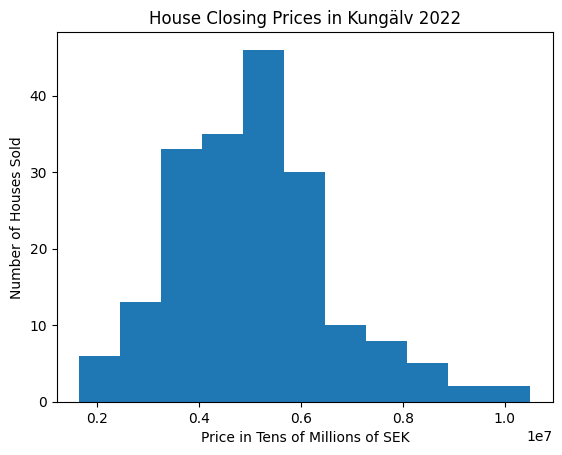

In [8]:
plt.hist(df_2022["Closing Price"], bins = 11)
plt.title("House Closing Prices in Kungälv 2022")
plt.xlabel("Price in Tens of Millions of SEK")
plt.ylabel("Number of Houses Sold")

Lastly, we graphed the relationship between closing price and living area (boarea) of the houses sold. We added colors to distinguish between how many rooms each house had.

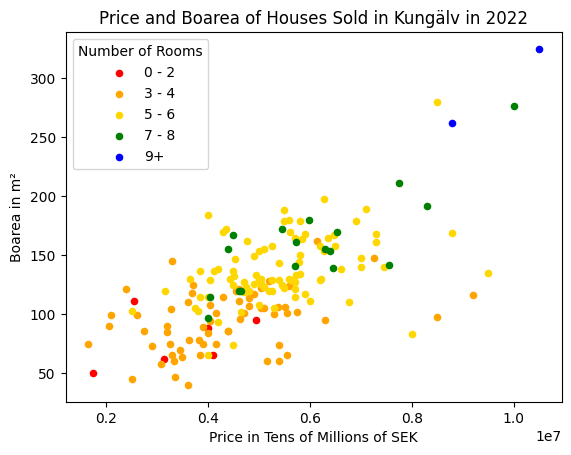

In [9]:
closing_prices = df_2022["Closing Price"]
boareas = df_2022["Living Area"].str.split("+").str[0].astype("float64")
rooms = df_2022["Rooms"]

plt.scatter(closing_prices[(rooms <= 2)], boareas[(rooms <= 2)], s = 20, color = 'red', label = '0 - 2')
plt.scatter(closing_prices[(rooms <= 4) & (rooms > 2)], boareas[(rooms <= 4) & (rooms > 2)], s = 20, color = 'orange', label = '3 - 4')
plt.scatter(closing_prices[(rooms <= 6) & (rooms > 4)], boareas[(rooms <= 6) & (rooms > 4)], s = 20, color = '#FFD700', label = '5 - 6')
plt.scatter(closing_prices[(rooms <= 8) & (rooms > 6)], boareas[(rooms <= 8) & (rooms > 6)], s = 20, color = 'green', label = '7 - 8')
plt.scatter(closing_prices[(rooms >= 9)], boareas[(rooms >= 9)], s = 20, color = 'blue', label = '9+')
plt.title("Price and Boarea of Houses Sold in Kungälv in 2022")
plt.xlabel("Price in Tens of Millions of SEK")
plt.ylabel("Boarea in m²")
plt.legend(title = "Number of Rooms")